TR AUTO - run 0

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from iminuit.cost import LeastSquares
import sys
sys.path.append('../src/analysis/fitting')  

from FitAPI import Fitter, Model
import models as md
from searcher import ResonancePeakSearcher

In [13]:
R_true = 2.317

def read_peaks_data_2(filename):
    data_dict = {}       # stores the dataset values as NumPy arrays
    metadata_dict = {}   # stores the metadata (attributes) for each dataset
    def process_dataset(name, obj):
        if isinstance(obj, h5py.Dataset):
            bias_voltage = float(obj.attrs.get("bias_voltage"))
            bias_key = bias_voltage/R_true 
            if bias_key is not None:
                data_dict[bias_key] = obj[()]
                metadata_dict[bias_key] = {k: v for k, v in obj.attrs.items()}
            else:
                print(f"Warning: Dataset '{name}' missing 'bias_voltage' attribute.")

    with h5py.File(filename, 'r') as f:
        f.visititems(process_dataset)

    return data_dict, metadata_dict

Fit for bias current 0.6905481225722917 failed (invalid result)
Fit for bias current 0.7768666378938281 failed (invalid result)
Fit for bias current 0.8631851532153646 failed (invalid result)
Fit for bias current 0.9495036685369012 failed (invalid result)
Fit for bias current 1.0358221838584376 failed (invalid result)
Fit for bias current 1.122140699179974 failed (invalid result)
Fit for bias current 1.2084592145015105 failed (invalid result)
Fit for bias current 1.294777729823047 failed (invalid result)
Fit for bias current 1.3810962451445834 failed (invalid result)
Fit for bias current 2.762192490289167 failed (invalid result)
Fit for bias current 3.021148036253776 failed (invalid result)


IndexError: index 6 is out of bounds for axis 0 with size 6

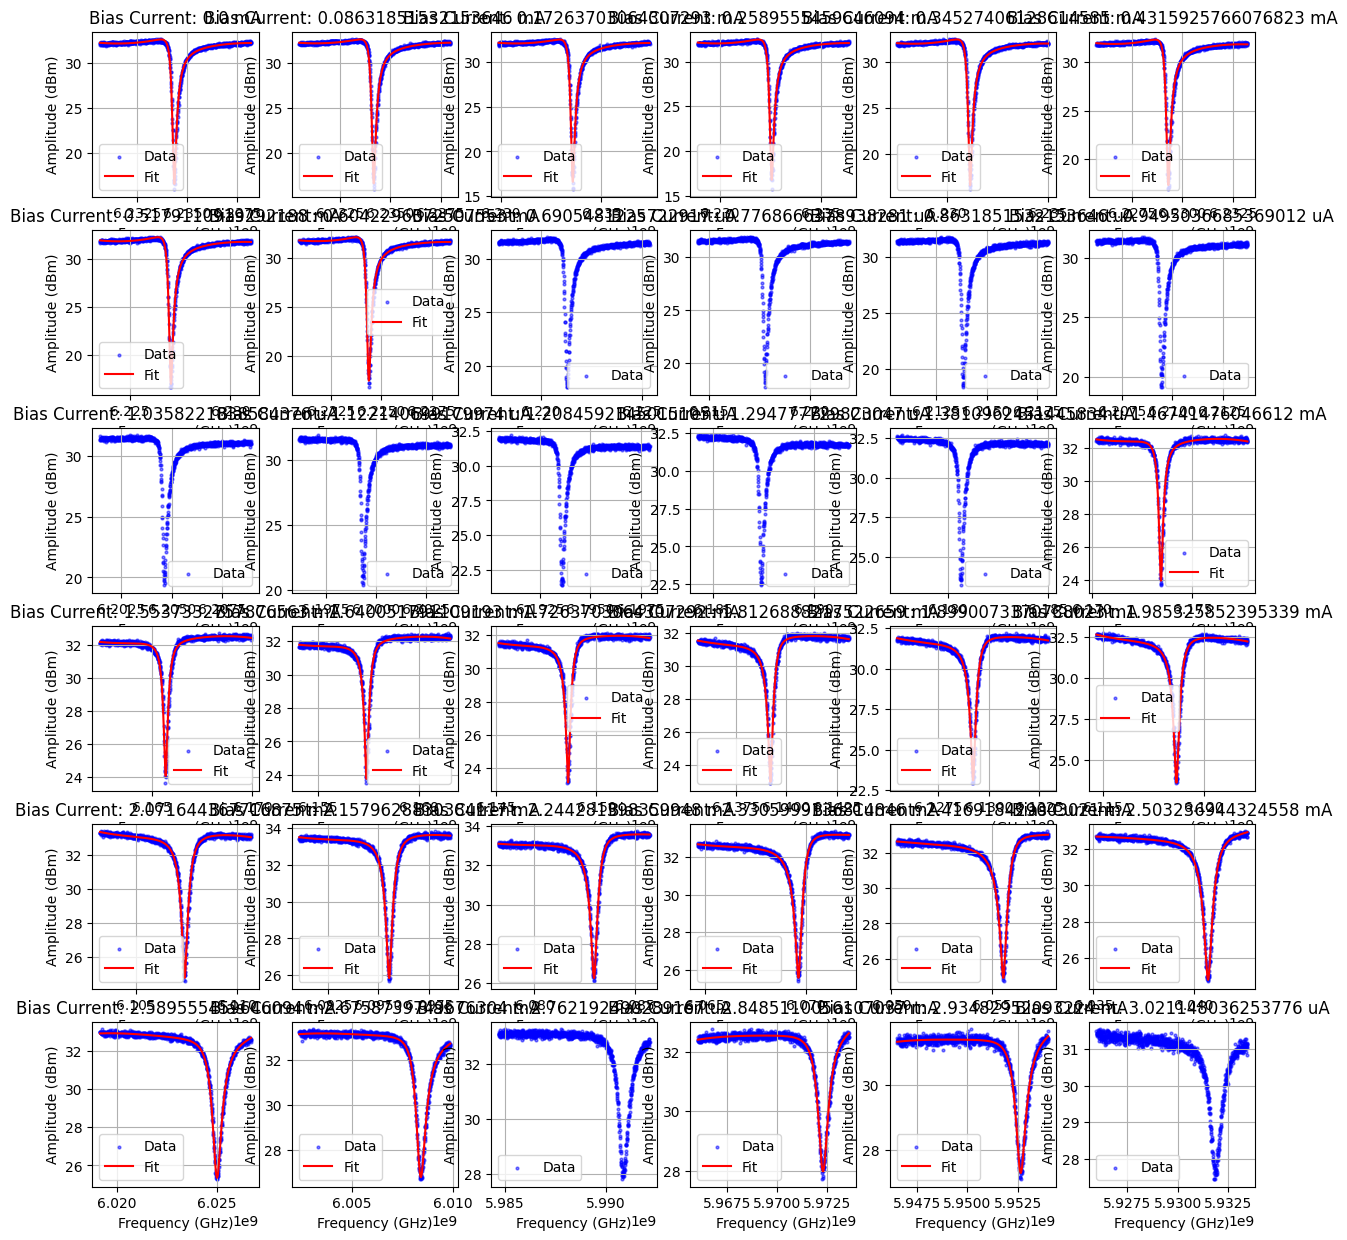

In [14]:
peak_data_dict, _ = read_peaks_data_2('../Experiments/TRswipeAuto/run-0/data/tr_sweep_data.h5')

resonance_frequneces = []
bias_currents = []

nof_peaks = len(peak_data_dict)
fig, ax = plt.subplots(int(np.sqrt(nof_peaks)), int(np.sqrt(nof_peaks)), figsize=(15, 15))
row_iter = 0
col_iter = 0


for bias_current, peak_data in peak_data_dict.items():
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]

    amp = np.sqrt(I**2 + Q**2)
    amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
    peak_data = np.array([f, amp_dBm]).T

    # try to fit
    model = md.resonance_model
    fitter = Fitter(model_function=md.resonance_model, 
                        param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"], 
                        data=peak_data, 
                        loss_function=LeastSquares
                    )

    searcher = ResonancePeakSearcher()
    result = fitter.fit(searcher=searcher)

    # Check if the fit was successful
    if result.valid:
        # p-value test
        p_value = fitter.p_value()
        if p_value < 0.05:
            print(f"Fit for bias current {bias_current} failed (p-value: {p_value})")
            # For now we take the fmin as the resonance frequency
            resonance_frequency = searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            bias_currents.append(bias_current)
            continue
        else:
            # Extract the resonance frequency from the fitted parameters
            resonance_frequency = result.values['f0'] + searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            bias_currents.append(bias_current)
            # Plot the fit result
            fitted_params = result.values.to_dict()
            fitted_params['fmin'] = searcher.params['fmin']
            ax[row_iter, col_iter].scatter(peak_data[:, 0], peak_data[:, 1], label='Data', color='blue', alpha=0.5, s=4)
            ax[row_iter, col_iter].plot(peak_data[:, 0], model(peak_data[:, 0], *fitted_params.values()), label='Fit', color='red')
            # add labels, title and legend
            ax[row_iter, col_iter].set_xlabel('Frequency (GHz)')
            ax[row_iter, col_iter].set_ylabel('Amplitude (dBm)')
            ax[row_iter, col_iter].set_title(f'Bias Current: {bias_current} mA')
            ax[row_iter, col_iter].legend()
            ax[row_iter, col_iter].grid()
    else:
        print(f"Fit for bias current {bias_current} failed (invalid result)")
        # For now we take the fmin as the resonance frequency
        resonance_frequency = searcher.params['fmin']
        resonance_frequneces.append(resonance_frequency)
        bias_currents.append(bias_current)
        # Plot anyway the data
        ax[row_iter, col_iter].scatter(peak_data[:, 0], peak_data[:, 1], label='Data', color='blue', alpha=0.5, s=4)
        # add labels, title and legend
        ax[row_iter, col_iter].set_xlabel('Frequency (GHz)')
        ax[row_iter, col_iter].set_ylabel('Amplitude (dBm)')
        ax[row_iter, col_iter].set_title(f'Bias Current: {bias_current} uA')
        ax[row_iter, col_iter].legend()
        ax[row_iter, col_iter].grid()

    # update iterators
    col_iter += 1
    if col_iter >= int(np.sqrt(nof_peaks)):
        col_iter = 0
        row_iter += 1

# adjust the layout
plt.tight_layout()
plt.show()

In [ ]:
# Renormalize the resonance frequencies with respect to the frequency at 0 bias current
resonance_frequneces_normalized = np.array(resonance_frequneces)
bias_currents = np.array(bias_currents)
resonance_frequneces_normalized -= resonance_frequneces[0]
resonance_frequneces_normalized /= resonance_frequneces[0] if resonance_frequneces[0] != 0 else 1

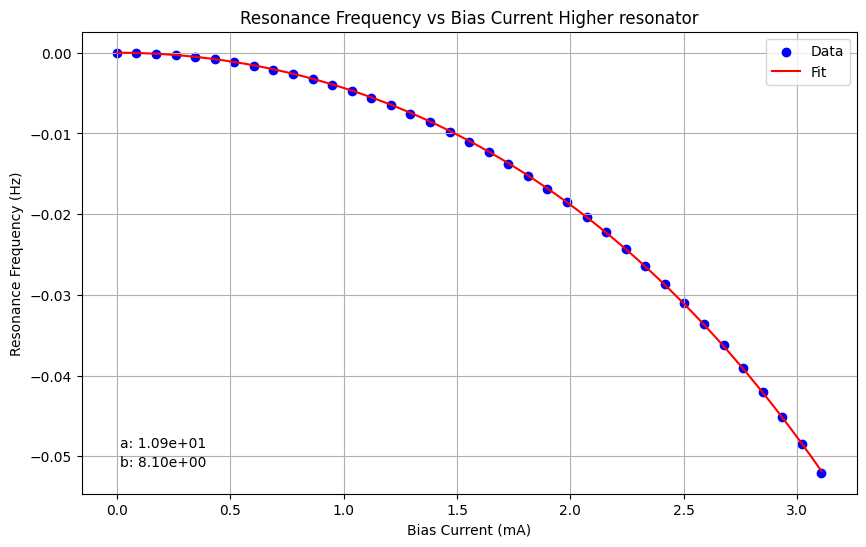

In [ ]:
# Fit resonance frequency vs bias current
model = md.parametric_resonator_peak_vs_bias_current
fitter = Fitter(model_function=model, 
                    param_names=["a", "b"], 
                    data=np.array([bias_currents, resonance_frequneces_normalized]).T, 
                    loss_function=LeastSquares,
                    params_initial_guess={"a": 1, "b": 1}, # initial guess for the parameters
                )



result = fitter.fit()
fitted_params = result.values.to_dict()

test_params = {
    "a": -1e4,
    "b": -1e3,
}

# Plot the resonance frequencies vs bias currents
plt.figure(figsize=(10, 6))
plt.scatter(bias_currents, resonance_frequneces_normalized, color='blue', label='Data')
linspace = np.linspace(min(bias_currents), max(bias_currents), 200)
plt.plot(linspace, model(linspace, *fitted_params.values()), label='Fit', color='red')
# plt.plot(bias_currents, model(bias_currents, *test_params.values()), label='Test', color='green', linestyle='--')
# Add a and b to the plot
plt.text(0.05, 0.1, f'a: {fitted_params["a"]:.2e}', transform=plt.gca().transAxes)
plt.text(0.05, 0.06, f'b: {fitted_params["b"]:.2e}', transform=plt.gca().transAxes)

plt.xlabel('Bias Current (mA)')
plt.ylabel('Resonance Frequency (Hz)')
plt.title('Resonance Frequency vs Bias Current Higher resonator')
plt.legend()
plt.grid()
plt.show()

F(I) gradient plot (to be fixed)

In [ ]:
peak_data

array([[5.90442000e+09, 3.19793455e+01],
       [5.90442751e+09, 3.20138021e+01],
       [5.90443502e+09, 3.20529305e+01],
       ...,
       [5.91190498e+09, 3.21541984e+01],
       [5.91191249e+09, 3.20554085e+01],
       [5.91192000e+09, 3.19723216e+01]])

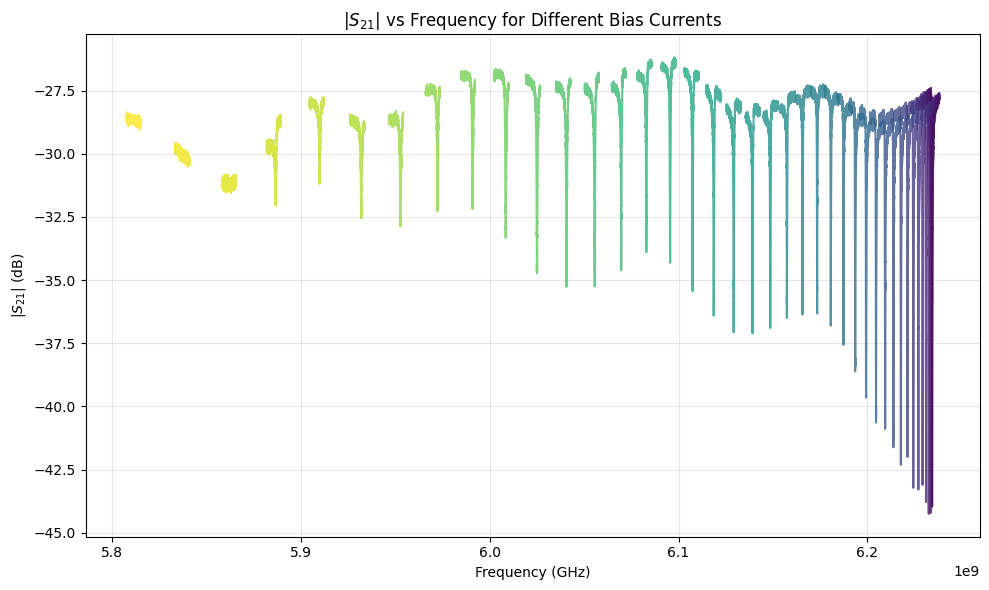

In [21]:
# ...existing code...
plt.figure(figsize=(10, 6))

# Trova i valori min e max dei bias current per normalizzare la colormap
all_bias_currents = list(peak_data_dict.keys())
vmin = min(all_bias_currents)
vmax = max(all_bias_currents)
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('viridis')

for bias_current in peak_data_dict.keys():
    data = peak_data_dict[bias_current]
    f = data[0]
    I = data[1]
    Q = data[2]
    S21_mag = 20 * np.log10(np.sqrt(I**2 + Q**2))
    color = cmap(norm(bias_current))
    plt.plot(f, S21_mag, color=color, linewidth=1.5, alpha=0.8)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


# Formatting
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'$|S_{21}|$ (dB)')
plt.title(r'$|S_{21}|$ vs Frequency for Different Bias Currents')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# ...existing code...